Source: https://www.youtube.com/watch?v=VMj-3S1tku0

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
# magic command that tells Matplotlib to display
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

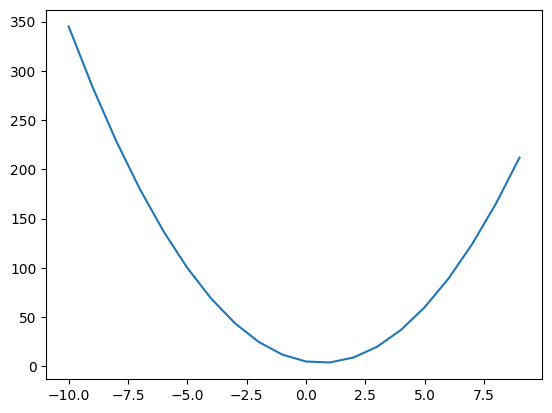

In [5]:
plt.plot(np.array(range(-10,10)), [f(x) for inx, x in enumerate(range(-10,10))])
plt.show()

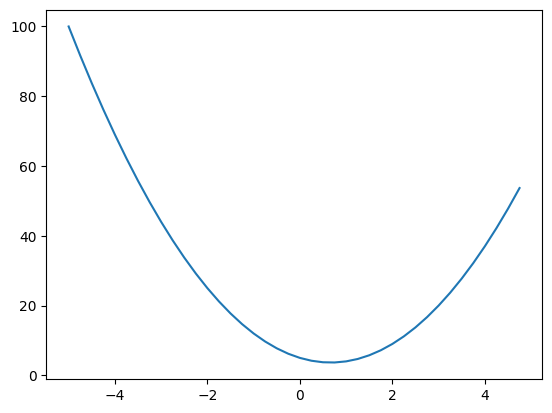

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.00000001
x = 2/3
actual_derivative = 6*x - 4
(f(x + h) - f(x))/h

0.0

In [8]:
actual_derivative

0.0

In [9]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# Building out the Value class (19:30 minutes)

In [207]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # by default assume value is not changing loss function
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    # for developers "dunder"
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a + b) # same as a.__add__(b)
print(b - a)
print(a*b)
d = a*b + c
d._prev

Value(data=-1.0)
Value(data=-5.0)
Value(data=-6.0)


{Value(data=-6.0), Value(data=10.0)}

In [19]:
# from graphviz import Digraph

# def trace(root):
#     nodes, edges = set(), set()
#     def build(v):
#         if v not in nodes:
#             nodes.add(v)
#             for child in v._prev:
#                 edges.add((child, v))
#                 build(child)
#     build(root)
#     return nodes, edges

# def draw_dot(root):
#     dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left to right
    
#     nodes, edges = trace(root)
#     for n in nodes:
#         uid = str(id(n))
#         # for value in graph, create a retangular ('record') node for it
#         dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
#         if n._op:
#             # if this value is a result of some operation, create an op node
#             dot.node(name = uid + n._op, label = n._op)
#             # and connect this node to it
#             dot.edge(uid + n._op, uid)
            
#     for n1, n2 in edges:
#         # connect n1 to the op node of n2
#         dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
#     return dot

In [39]:
# dL / de = -2.0
# dL / dd = -2.0
# dd / de = 1
# de/da = b = -3
# dL / da = ?
# dL / da = de/da * dd/de * dL / dd

def lol():
    
    h = 0.0001
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

-6.000000000021544


# Neuron modelling



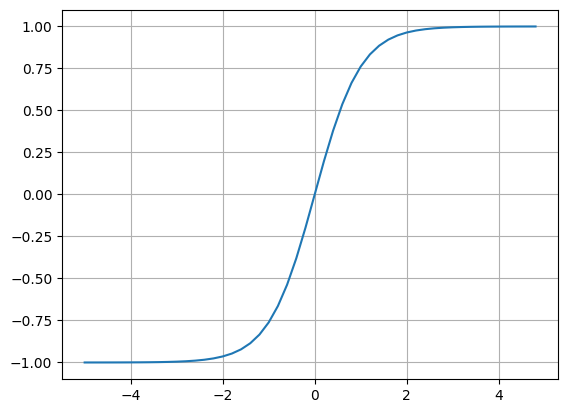

In [42]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [65]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o

Value(data=0.7071067811865476)

In [55]:
o.grad = 1.0

n.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = 0.5 #do/dx2 = dx2w2/dx2 * do/dx2w2 = w2 * do/dx2w2
w2.grad = 0 #do/dw2 = dx2w2/dw2 * do/dx2w2 = x2 * do/dx2w2

x1.grad = -1.5
w1.grad = 1.0

Value(data=0.7071067811865476)

In [ ]:
# o = tanh(n)
# do/dh = 1 - (tanh(x))^2 = 1 - o**2 = 1 - 0.5

In [88]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
o = n.tanh(); o.label = 'o'
# ---
o.backward()

# Now doing it all in PyTorch (1:39:00)

In [121]:
import torch
    
# inputs x1,x2
x1 = torch.Tensor([2.0]).double()                              ; x1.requires_grad = True # leaf nodes assume that they do not require gradients
x2 = torch.Tensor([0.0]).double()                              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                             ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()                ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print(f"w2 {w2.grad.item()}")
print(f"x1 {x1.grad.item()}")
print(f"w1 {w1.grad.item()}")

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [123]:
torch.tensor([[1, 2, 3], [4, 5, 6]]).shape

torch.Size([2, 3])

In [182]:
o.data

tensor([0.7071], dtype=torch.float64)

In [216]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [323]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

In [328]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.024250302803611647
1 0.023553959704913238
2 0.022893647261914844
3 0.022266716132800683
4 0.021670766878646316
5 0.021103621419276353
6 0.02056329829332494
7 0.02004799114601538
8 0.019556049965638207
9 0.019085964669048376
10 0.01863635070139096
11 0.018205936368562
12 0.01779355166486553
13 0.017398118394729198
14 0.017018641417592642
15 0.016654200870325396
16 0.016303945242659976
17 0.015967085198877854
18 0.01564288805394487
19 0.01533067282494033


In [329]:
ypred

[Value(data=0.9628200081111118),
 Value(data=-0.9563101708397671),
 Value(data=-0.9219905966433162),
 Value(data=0.9228374906838405)]